<a href="https://colab.research.google.com/github/apoorwagupta/COVID19-Triage/blob/main/vgg16%2Bvgg19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, confusion_matrix

# deep learning libraries
import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import applications
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dense, Dropout
from keras.preprocessing import image

import cv2

import warnings
warnings.filterwarnings('ignore')


In [5]:
import os
import cv2

import matplotlib.patches as patches
import random
from sklearn.utils import shuffle
from glob import glob
import seaborn as sns


import torch
import torchvision.models as models
from torchvision import datasets, transforms
from torch import optim
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data.sampler import SubsetRandomSampler
import random
from termcolor import colored
from sklearn.metrics import confusion_matrix
import itertools
from sklearn.model_selection import train_test_split


import matplotlib.patches as patches
from PIL import Image
from matplotlib.colors import ListedColormap
from matplotlib.gridspec import GridSpec

In [6]:
from google.colab import drive
drive.mount("/content/drive")
  

Mounted at /content/drive


In [7]:
import zipfile
import os

zip_ref = zipfile.ZipFile('/content/drive/MyDrive/cancerhistologydataset.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/base_dir') #Extracts the files into the /base_dir folder
zip_ref.close()

In [8]:
len(os.listdir('/base_dir/Kather_texture_2016_image_tiles_5000/Kather_texture_2016_image_tiles_5000'))

8

In [9]:
base_dir = '/base_dir/Kather_texture_2016_image_tiles_5000/Kather_texture_2016_image_tiles_5000'

In [11]:
## Get labels of all classes in this dataset
img_labels = [i for i in os.listdir(base_dir) if not i.startswith('.')]
print('There are {} classes in this dataset:\n{}'.format(len(img_labels), img_labels))

There are 8 classes in this dataset:
['05_DEBRIS', '03_COMPLEX', '01_TUMOR', '06_MUCOSA', '04_LYMPHO', '08_EMPTY', '02_STROMA', '07_ADIPOSE']


In [12]:
tumor_files = glob(os.path.join(base_dir, img_labels[0], '*.tif'))
stroma_files = glob(os.path.join(base_dir, img_labels[1], '*.tif'))
complex_files = glob(os.path.join(base_dir, img_labels[2], '*.tif'))
lympho_files = glob(os.path.join(base_dir, img_labels[3], '*.tif'))
debris_files = glob(os.path.join(base_dir, img_labels[4], '*.tif'))
mucosa_files = glob(os.path.join(base_dir, img_labels[5], '*.tif'))
adipose_files = glob(os.path.join(base_dir, img_labels[6], '*.tif'))
empty_files = glob(os.path.join(base_dir, img_labels[7], '*.tif'))
img_files = [tumor_files, stroma_files, complex_files, lympho_files, debris_files, mucosa_files, adipose_files, empty_files]
total_files = [img for folder in img_files for img in folder]

In [13]:
def image_summary(image_paths, img_label):
    img_dict = {}
    for i in range(len(image_paths)):
        img_path = image_paths[i]
        img_dict[img_path] = {}
        img = cv2.imread(img_path)
        img_dict[img_path]['label'] = img_label
        img_dict[img_path]['max'] = img.max()  #smallest and largest pixel values for pixel in a grayscale image as follows
        img_dict[img_path]['min'] = img.min()
        
        channel_mean = img.mean(axis = (0,1), keepdims = True).squeeze()
        channel_std = img.std(axis = (0,1), keepdims = True).squeeze()
        channel_q01 = np.quantile(img, 0.1, axis=(0,1), keepdims=True).squeeze()
        channel_q09 = np.quantile(img, 0.9, axis=(0,1), keepdims=True).squeeze()
        img_dict[img_path]['red_mean'], img_dict[img_path]['green_mean'], img_dict[img_path]['blue_mean'] = channel_mean #to see what individual channels contribute
        img_dict[img_path]['red_std'], img_dict[img_path]['green_std'], img_dict[img_path]['blue_std'] = channel_std 
        img_dict[img_path]['red_q01'], img_dict[img_path]['green_q01'], img_dict[img_path]['blue_q01'] = channel_q01
        img_dict[img_path]['red_q09'], img_dict[img_path]['green_q09'], img_dict[img_path]['blue_q09'] = channel_q09
        
    img_df = pd.DataFrame.from_dict(img_dict, orient = 'index')
    return img_df

In [14]:
tumor_files_df = image_summary(tumor_files, 'TUMOR')
stroma_files_df = image_summary(stroma_files, 'STROMA')
complex_files_df = image_summary(complex_files, 'COMPLEX')
lympho_files_df = image_summary(lympho_files, 'LYMPHO')
debris_files_df = image_summary(debris_files, 'DEBRIS')
mucosa_files_df = image_summary(mucosa_files, 'MUCOSA')
adipose_files_df = image_summary(adipose_files, 'ADIPOSE')
empty_files_df = image_summary(empty_files, 'EMPTY')

In [15]:
pixel_df = pd.concat([tumor_files_df, stroma_files_df, complex_files_df, lympho_files_df, debris_files_df, mucosa_files_df, adipose_files_df, empty_files_df])
pixel_df.shape

(5000, 15)

In [16]:
#train_datagen = ImageDataGenerator( rescale = 1.0/255,shear_range=0.2,zoom_range=0.2)

In [17]:
pixel_df.to_csv('Colorectal_histology_mnist_pixel_df.csv', index_label = 'img_id')
pixel_df = pd.read_csv('Colorectal_histology_mnist_pixel_df.csv', index_col = 'img_id')

In [18]:
pip install split-folders


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [19]:
import splitfolders

In [20]:
splitfolders.ratio(base_dir,output="datasetaftersplit",seed=35, ratio= (0.7,0.15,0.15), group_prefix = None)

Copying files: 5000 files [00:01, 4261.77 files/s]


In [21]:
CATEGORIES = ['04_LYMPHO', '07_ADIPOSE', '06_MUCOSA', '05_DEBRIS', '01_TUMOR', '08_EMPTY', '03_COMPLEX', '02_STROMA']
for category in CATEGORIES:
    print('{} {} images'.format(category, len(os.listdir(os.path.join('/content/datasetaftersplit/train/', category)))))

04_LYMPHO 437 images
07_ADIPOSE 437 images
06_MUCOSA 437 images
05_DEBRIS 437 images
01_TUMOR 437 images
08_EMPTY 437 images
03_COMPLEX 437 images
02_STROMA 437 images


In [22]:
from tensorflow.keras.layers import Input

In [23]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.models import load_model
from keras.models import Model

In [24]:
def save_history(history, model_name):
    #convert the history.history dict to a pandas DataFrame:     
    hist_df = pd.DataFrame(history.history) 

    # save to json:  
    hist_json_file = model_name+'_history.json' 
    with open(hist_json_file, mode='w') as f:
        hist_df.to_json(f)

    # or save to csv: 
    hist_csv_file = model_name+'_history.csv'
    with open(hist_csv_file, mode='w') as f:
        hist_df.to_csv(f)
        
def plot_accuracy_from_history(history, isinception=False):
    color = sns.color_palette()
    if(isinception == False):
        acc = history.history['acc']
        val_acc = history.history['val_acc']
    else:
        acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']
    

    epochs = range(len(acc))

    sns.lineplot(epochs, acc, label='Training Accuracy')
    sns.lineplot(epochs, val_acc,label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.figure()
    plt.show()
    
def plot_loss_from_history(history):
    color = sns.color_palette()
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(len(loss))
    
    sns.lineplot(epochs, loss,label='Training Loss')
    sns.lineplot(epochs, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.figure()
    plt.show()
    
def do_history_stuff(history, history_file_name, isinception=False):
    save_history(history, history_file_name)
    plot_accuracy_from_history(history, isinception)
    plot_loss_from_history(history)

Number of images in the train set :  3496
Number of images in the test set :  760


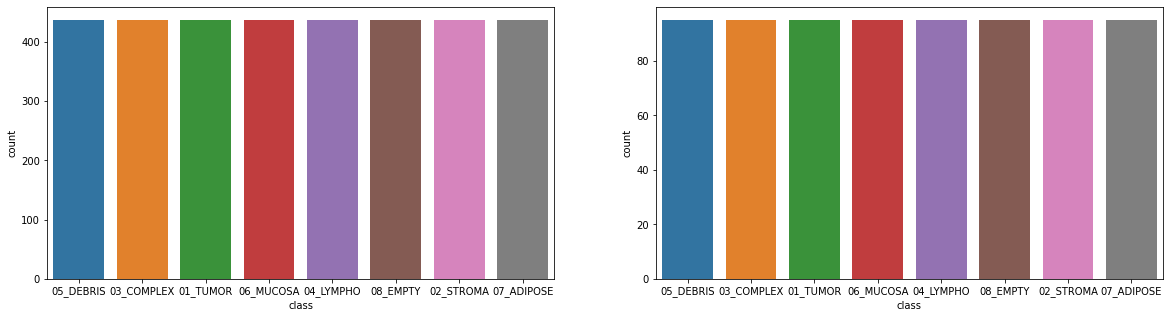

In [25]:
root_path = '/base_dir/Kather_texture_2016_image_tiles_5000/Kather_texture_2016_image_tiles_5000'
train_pred_test_folders = os.listdir(root_path)

seg_train_folders = '/content/datasetaftersplit/train/' #one more seg_train folder within
seg_test_folders = '/content/datasetaftersplit/test/'

quantity_tr = {} 
quantity_te = {}
for folder in os.listdir(seg_train_folders):
    quantity_tr[folder] = len(os.listdir(seg_train_folders+folder))


for folder in os.listdir(seg_test_folders):
    quantity_te[folder] = len(os.listdir(seg_test_folders+folder))
    
quantity_train = pd.DataFrame(list(quantity_tr.items()), index=range(0,len(quantity_tr)), columns=['class','count'])
quantity_test = pd.DataFrame(list(quantity_te.items()), index=range(0,len(quantity_te)), columns=['class','count'])

figure, ax = plt.subplots(1,2,figsize=(20,5))
sns.barplot(x='class',y='count',data=quantity_train,ax=ax[0])
sns.barplot(x='class',y='count',data=quantity_test,ax=ax[1])

print("Number of images in the train set : ", sum(quantity_tr.values()))
print("Number of images in the test set : ",sum(quantity_te.values()))


plt.show()

In [26]:
train_datagen = ImageDataGenerator( rescale = 1.0/255,shear_range=0.2,
        rotation_range=10, # rotation
        width_shift_range=0.2, # horizontal shift
        height_shift_range=0.2, # vertical shift
        zoom_range=0.2, # zoom
        horizontal_flip=True) # horizontal flip
       

The ImageDataGenerator is not returning both the original data and the transformed data — the class only returns the randomly transformed 


In [27]:
validation_datagen = ImageDataGenerator(rescale = 1.0/255,rotation_range=10, # rotation
        width_shift_range=0.2, # horizontal shift
        height_shift_range=0.2, # vertical shift
        zoom_range=0.2, # zoom
        horizontal_flip=True,vertical_flip = True) 
      

In [28]:
test_datagen = ImageDataGenerator(rescale = 1.0/255,rotation_range=10, # rotation
        width_shift_range=0.2, # horizontal shift
        height_shift_range=0.2, # vertical shift
        zoom_range=0.2, # zoom
        horizontal_flip=True,vertical_flip = True) # horizontal flip
      

In [29]:

# we are rescaling by 1.0/255 to normalize the rgb values if they are in range 0-255 the values are too high for good model performance. 
train_generator = train_datagen.flow_from_directory('/content/datasetaftersplit/train',
                                                    batch_size=32,
                                                    shuffle=True,
                                                    class_mode='categorical',
                                                    color_mode="rgb",
                                                    seed=2020,
                                                    target_size=(244, 244))

test_generator = test_datagen.flow_from_directory("/content/datasetaftersplit/test",   
                                                    batch_size=32,
                                                    shuffle=True,
                                                    class_mode='categorical',
                                                    color_mode="rgb",
                                                    seed=2020,
                                                    target_size=(244, 244))


validation_generator = validation_datagen.flow_from_directory('/content/datasetaftersplit/val',   batch_size=32,
                                                    shuffle=True,
                                                    class_mode='categorical',
                                                    color_mode="rgb",
                                                    seed=2020,
                                                    target_size=(244, 244))


Found 3496 images belonging to 8 classes.
Found 760 images belonging to 8 classes.
Found 744 images belonging to 8 classes.


In [30]:
x,y = next(train_generator)
x.shape # input shape of one record is (331,331,3) , 32: is the batch size

(32, 244, 244, 3)

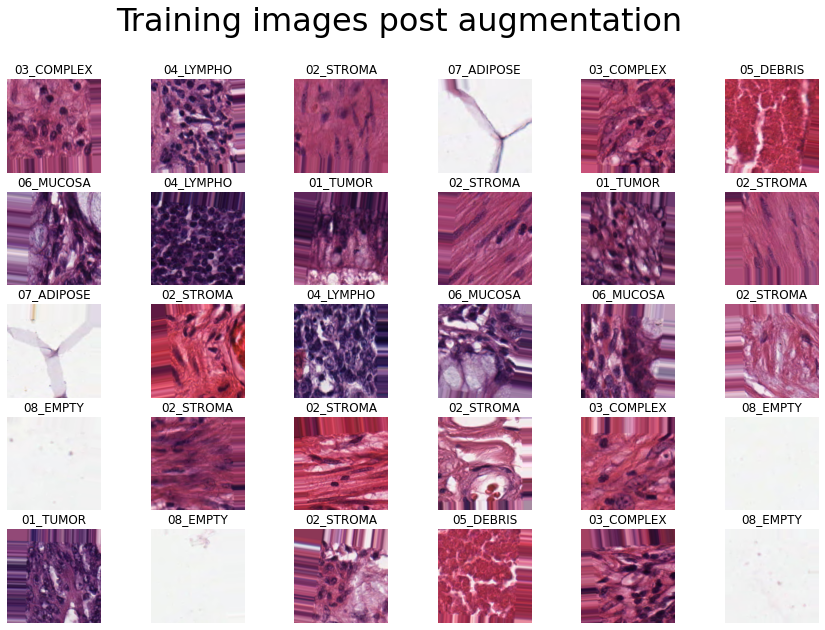

In [31]:
a = train_generator.class_indices
class_names = list(a.keys()) # storing class names in a list
  
def plot_images(img,labels):
    fig= plt.figure(figsize=[15,10])
    for i in range(30):
        plt.subplot(5,6,i+1)
        plt.imshow(img[i])
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis('off')
        fig.suptitle('Training images post augmentation', fontsize = 32)  
plot_images(x,y)

'acc' refers to accuracy of what was trained against. 'val_acc' refers to validation set. Note that val_acc refers to a set of samples that was not shown to the network during training and hence refers to how much your model works in general for cases outside the training set.

It is common for validation accuracy to be lower than accuracy. But ideally, you should strive to keep those values at the same level. If validation accuracy is much lower than accuracy, you are certainly over fitting (like in the example a) - where the accuracy is 84 and validation accuracy is 77.

In [32]:
from tensorflow.keras.optimizers import SGD,Adam
from keras.callbacks import ReduceLROnPlateau

In [33]:
from tensorflow.keras.optimizers import RMSprop

In [35]:
vgg16_model = VGG16(pooling='avg', weights='imagenet', include_top=False, input_shape=(244,244,3))
for layers in vgg16_model.layers:
            layers.trainable=False
last_output = vgg16_model.layers[-1].output
vgg_x = Flatten()(last_output)
vgg_x = Dense(128, activation = 'relu')(vgg_x) #128 hidden neurons
vgg_x  = keras.layers.Dense(100, activation='relu')(vgg_x )
vgg_x  = keras.layers.Dense(100, activation='relu')(vgg_x )
vgg_x  = keras.layers.Dense(100, activation='relu')(vgg_x )
vgg_x = Dense(8, activation = 'softmax')(vgg_x) #final softmax layer
vgg16_final_model = Model(vgg16_model.input, vgg_x)
opt = Adam(lr=0.001)
vgg16_final_model.compile(loss = 'categorical_crossentropy', optimizer= opt, metrics=['acc'])
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.05, patience=5, min_lr=0.000002)
vgg16_final_model.summary()
# VGG16
number_of_epochs = 50
vgg16_filepath = 'vgg_16_'+'-saved-model-{epoch:02d}-acc-{val_acc:.2f}.hdf5'
vgg_checkpoint = tf.keras.callbacks.ModelCheckpoint(vgg16_filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
vgg_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
vgg16_history = vgg16_final_model.fit(train_generator, epochs = number_of_epochs ,validation_data = validation_generator,callbacks=[vgg_checkpoint,vgg_early_stopping,reduce_lr],verbose=1)


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 244, 244, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 244, 244, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 244, 244, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 122, 122, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 122, 122, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 122, 122, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 61, 61, 128)       0   

In [37]:
#changed learning rate and rmsprp optimiser used.
#each pixel = mix of rgb 
# rgb takes values of all red color values of each pixel, green avg = avg of all green color values of each. in last we have r avg, g avg, b avg.

In [36]:
accuracy_score = vgg16_final_model.evaluate(validation_generator)
print(accuracy_score)
print("Accuracy: {:.4f}%".format(accuracy_score[1] * 100))
print("Loss: ",accuracy_score[0])

24/24 [==============================] - 10s 413ms/step - loss: 0.3511 - acc: 0.8723
[0.3510914742946625, 0.8723118305206299]
Accuracy: 87.2312%
Loss:  0.3510914742946625


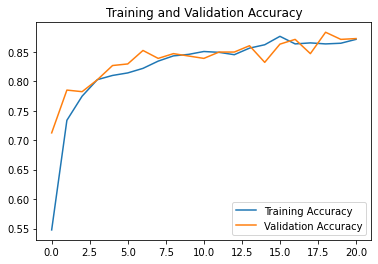

<Figure size 432x288 with 0 Axes>

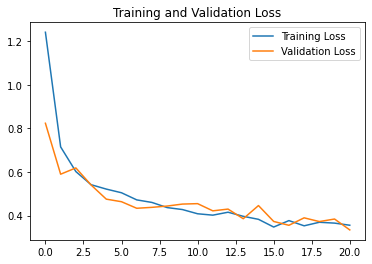

<Figure size 432x288 with 0 Axes>

In [38]:
do_history_stuff(vgg16_history, 'vgg16_model')

In [39]:
#sgd optimiser used

In [40]:
#Create a VGG19 model, and removing the last layer that is classifying 1000 images. This will be replaced with images classes we have. 
vgg19_model = VGG19(input_shape=(244,244,3), weights='imagenet', include_top=False)
# This sets the base that the layers are not trainable. If we'd want to train the layers with custom data, these two lines can be ommitted. 
for layer in vgg19_model.layers:
  layer.trainable = False
vgg_x19 = Flatten()(vgg19_model.output) #Output obtained on vgg19 is now flattened. 

#Creating model object 
vgg_x19 = keras.layers.Dense(100, activation='relu')(vgg_x19)
vgg_x19 = keras.layers.Dense(100, activation='relu')(vgg_x19)
vgg_x19 = keras.layers.Dense(100, activation='relu')(vgg_x19)
vgg_x19 = Dense(128, activation = 'relu')(vgg_x19)
vgg_x19 = Dense(8, activation = 'softmax')(vgg_x19) # We have 8 classes, and so, the prediction is being done on len(foldeimg_filrs) - 8 classes
vgg19_final_model = Model(vgg19_model.input, vgg_x19)
vgg19_filepath = 'vgg_19_'+'-saved-model-{epoch:02d}-acc-{val_acc:.2f}.hdf5'
vgg19_checkpoint = tf.keras.callbacks.ModelCheckpoint(vgg19_filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.05, patience=5, min_lr=0.000002)
vgg19_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
callbacklist = [vgg19_checkpoint,vgg19_early_stopping,reduce_lr]
# vgg19_final_model.summary()
#Compile the model 
number_of_epochs = 50

vgg19_final_model.compile(loss = 'categorical_crossentropy', optimizer= 'adam', metrics=['acc'])
vgg19_history = vgg19_final_model.fit(train_generator, epochs = number_of_epochs ,validation_data = validation_generator,callbacks=callbacklist,verbose=1)


80134624/80134624 [==============================] - 1s 0us/step
Epoch 1/50
110/110 [==============================] - ETA: 0s - loss: 1.1894 - acc: 0.5369
Epoch 1: val_acc improved from -inf to 0.71640, saving model to vgg_19_-saved-model-01-acc-0.72.hdf5
110/110 [==============================] - 61s 547ms/step - loss: 1.1894 - acc: 0.5369 - val_loss: 0.8184 - val_acc: 0.7164 - lr: 0.0010
Epoch 2/50
110/110 [==============================] - ETA: 0s - loss: 0.7354 - acc: 0.7274
Epoch 2: val_acc improved from 0.71640 to 0.81317, saving model to vgg_19_-saved-model-02-acc-0.81.hdf5
110/110 [==============================] - 60s 542ms/step - loss: 0.7354 - acc: 0.7274 - val_loss: 0.5546 - val_acc: 0.8132 - lr: 0.0010
Epoch 3/50
110/110 [==============================] - ETA: 0s - loss: 0.5591 - acc: 0.7949
Epoch 3: val_acc improved from 0.81317 to 0.81586, saving model to vgg_19_-saved-model-03-acc-0.82.hdf5
110/110 [==============================] - 61s 551ms/step - loss: 0.5591 - acc:

In [44]:
accuracy_score = vgg19_final_model.evaluate(validation_generator)
print(accuracy_score)
print("Accuracy: {:.4f}%".format(accuracy_score[1] * 100))
print("Loss: ",accuracy_score[0])

24/24 [==============================] - 11s 445ms/step - loss: 0.3393 - acc: 0.8804
[0.3392559885978699, 0.8803763389587402]
Accuracy: 88.0376%
Loss:  0.3392559885978699


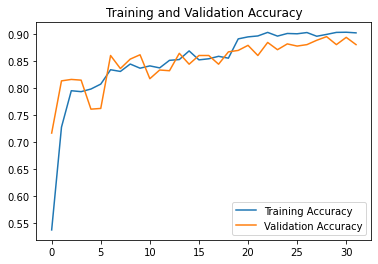

<Figure size 432x288 with 0 Axes>

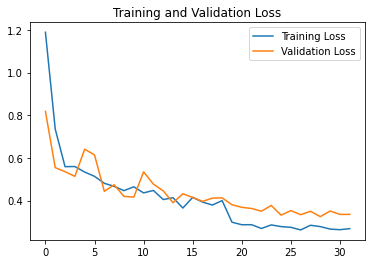

<Figure size 432x288 with 0 Axes>

In [41]:
do_history_stuff(vgg19_history, 'vgg19_model')

In [42]:
vgg_best_model = vgg16_final_model 
vgg19_best_model=vgg19_final_model

In [43]:
vgg_pred = []
vgg19_pred = []

Model Accuracy 0.5171052631578947
              precision    recall  f1-score   support

    01_TUMOR       0.76      0.20      0.32        95
   02_STROMA       0.61      0.77      0.68        95
  03_COMPLEX       0.64      0.09      0.17        95
   04_LYMPHO       0.00      0.00      0.00        95
   05_DEBRIS       0.21      0.83      0.33        95
   06_MUCOSA       1.00      0.31      0.47        95
  07_ADIPOSE       0.95      0.97      0.96        95
    08_EMPTY       0.98      0.97      0.97        95

    accuracy                           0.52       760
   macro avg       0.64      0.52      0.49       760
weighted avg       0.64      0.52      0.49       760



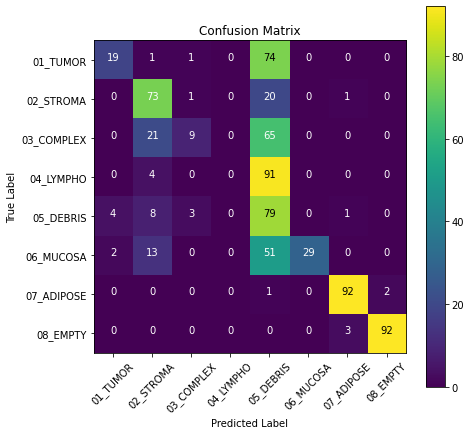

In [48]:
# VGG model classification report
clf_report(true_value, vgg_pred)


In [45]:
from sklearn.metrics import confusion_matrix
import itertools
#from mlxtend.plotting import plot_confusion_matrix
def clf_report(true_value, model_pred):
    
    classes = test_generator.class_indices.keys()
    TP_count = [true_value[i] == model_pred[i] for i in range(len(true_value))]
    model_accuracy = np.sum(TP_count)/len(TP_count)
    print('Model Accuracy', model_accuracy)
    
    plt.figure(figsize=(7,7))
    cm = confusion_matrix(true_value,model_pred)
    plt.imshow(cm,interpolation='nearest',cmap=plt.cm.viridis)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max()*0.8
    for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,cm[i,j],
                horizontalalignment="center",
                color="black" if cm[i,j] > thresh else "white")
        pass
    
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    pass
    
    print(classification_report(true_value, model_pred, target_names = list(classes)))
    

In [46]:
from collections import Counter

In [47]:

def mode(my_list):
    ct = Counter(my_list)
    max_value = max(ct.values())
    return ([key for key, value in ct.items() if value == max_value])

true_value = []
combined_model_pred = []


for folder in os.listdir(seg_test_folders):
    
    test_image_ids = os.listdir(os.path.join(seg_test_folders,folder))
    
    for image_id in test_image_ids[:int(len(test_image_ids))]:
        
        path = os.path.join(seg_test_folders,folder,image_id)
        
        true_value.append(validation_generator.class_indices[folder])
        img = cv2.resize(cv2.imread(path),(244,244))
        img_normalized = img/255
        #vgg
        vgg16_image_prediction = np.argmax(vgg_best_model.predict(np.array([img_normalized])))
        vgg_pred.append(vgg16_image_prediction)
        vgg19_image_prediction = np.argmax(vgg19_best_model.predict(np.array([img_normalized])))
        vgg19_pred.append(vgg19_image_prediction)
       
       
        
        #giving vgg16 high priority if they all predict something different
        image_prediction = mode([vgg16_image_prediction, vgg19_image_prediction])                                  
        combined_model_pred.append(image_prediction)

1/1 [==============================] - 0s 19ms/step


Model Accuracy 0.5986842105263158
              precision    recall  f1-score   support

    01_TUMOR       0.68      0.57      0.62        95
   02_STROMA       0.55      0.69      0.61        95
  03_COMPLEX       0.56      0.26      0.36        95
   04_LYMPHO       0.00      0.00      0.00        95
   05_DEBRIS       0.24      0.60      0.35        95
   06_MUCOSA       0.84      0.73      0.78        95
  07_ADIPOSE       0.95      0.97      0.96        95
    08_EMPTY       0.98      0.97      0.97        95

    accuracy                           0.60       760
   macro avg       0.60      0.60      0.58       760
weighted avg       0.60      0.60      0.58       760



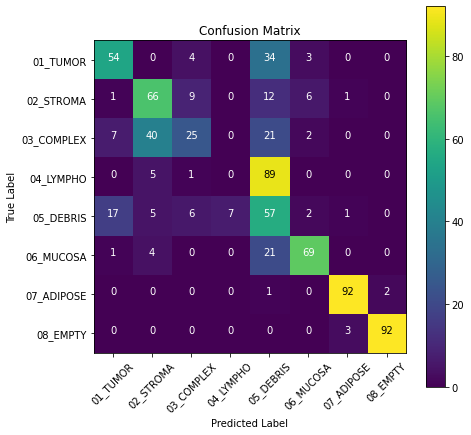

In [49]:
clf_report(true_value, vgg19_pred)